<div class="infotext" style='padding:0.1em; color:#000000'>
<span>
<p style='margin-top:1em; text-align:center'><font size="10"><b>Analysis of French Motor Third-Party Liability Claims in Python</b></font></p>
<p style='margin-left:1em;'><font size="4">

The goal of the following notebook is to reproduce, at least in part, some of the results presented in the original claim frequency modeling tutorial coded in <code>R</code> by Noll, Salzmann and Wüthrich [1] but this time using <code>Python</code>.
    
We consider the same third-party liability insurance dataset <a href='https://www.openml.org/search?type=data&sort=runs&id=41214&status=active'><code>freMTPL2freq</code></a> included in the <code>R</code> package <code>CASdatasets</code> [2] to explore some the most popular supervised learning methods for predictive modeling:  Generalized Linear Models (GLM), Gradient Boosting Machines (GBM) and Artificial Neural Networks.
    
<b>Work still in progress...</b>
</font></p>
</span>
</div>

<font size="6"><b>Table of contents</b></font><br>
<ul><font size="4">
<li><a href="#Import">Import Modules</a></li>
<li><a href="#EDA">Exploratory Data Analysis</a></li>
<li><a href="#GLM">Generalized Linear Models</a></li>
<li><a href="#RT">Regression Trees</a></li>
<li><a href="#ANN">Artificial Neural Networks</a></li>
</font></ul>
 
<font size="6"><b>References</b></font>
<ol><font size="4">
<li><p>Noll, Alexander and Salzmann, Robert and Wüthrich, Mario V., <cite>Case Study: French Motor Third-Party Liability Claims</cite>, (March 4, 2020). Available at SSRN: <a href="https://ssrn.com/abstract=3164764">https://ssrn.com/abstract=3164764</a> or <a href="https://dx.doi.org/10.2139/ssrn.3164764">https://dx.doi.org/10.2139/ssrn.3164764</a></p></li>
    
<li><p><cite>CASdatasets Package Vignette (2016)</cite>. Reference Manual, May 28, 2016. Version 1.0-6. Available from <a href="http://cas.uqam.ca">http://cas.uqam.ca</a>.</p></li>
</font>
</ol>



<a id="Import"></a>

# Import Modules

In [144]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

warnings.filterwarnings('ignore')


In [145]:
#h2o.shutdown()

## Helper Functions

In [146]:
def plot_results(target_train, prediction_train, target_test, prediction_test):
    
    fig, ax = plt.subplots(1, 2, figsize = (10,5), sharex=True, sharey = True, constrained_layout = True)

    ax[0].plot(target_train, prediction_train, 'o', color = 'r')
    ax[0].set_ylabel('Model Predictions')
    ax[0].set_xlabel('True Values')
    ax[0].set_title('Training Dataset')

    ax[1].plot(target_test, prediction_test, 'o', color = 'r')
    ax[1].set_ylabel('Model Predictions')
    ax[1].set_xlabel('True Values')
    ax[1].set_title('Test Dataset')

<a id="EDA"></a>

# Exploratory Data Analysis

## Data Loading

In [147]:
# Retrieve dataset with Scikit-Learn
dataset = fetch_openml(name="freMTPL2freq", as_frame=True)
#dataset.DESCR

## Data Description

The dataset `freMTPL2freq` contains 678,013 individual car insurance policies and for each policy we have 12 risk features observed mostly on one year which can be described as follows:

<ul>
    <li><b>IDpol</b>: policy number (unique identifier)</li>
    <li><b>ClaimNb</b>: number of claims on the given policy</li>
    <li><b>Exposure</b>: total exposure in yearly units</li>
    <li><b>Area</b>: area code (categorical, ordinal)</li>
    <li><b>VehPower</b>: power of the car (categorical, ordinal)</li>
    <li><b>VehAge</b>: age of the car in years</b></li>
    <li><b>DrivAge</b>: age of the (most common) driver in years</li>
    <li><b>BonusMalus</b>: bonus-malus level between 50 and 230 (with reference level 100)</li>
    <li><b>VehBrand</b>: car brand (categorical, nominal)</li>
    <li><b>VehGas</b>: diesel or regular fuel car (binary)</li>
    <li><b>Density</b>: density of inhabitants per km2 in the city of the living place of the driver</li>
    <li><b>Region</b>: regions in France (prior to 2016), these are illustrated in Figure 1 (categorical)</li>
</ul>    


In [148]:
# Retrieve pandas dataframe from dataset
df = dataset.frame
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  float64 
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  float64 
 5   VehAge      678013 non-null  float64 
 6   DrivAge     678013 non-null  float64 
 7   BonusMalus  678013 non-null  float64 
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  float64 
 11  Region      678013 non-null  category
dtypes: category(3), float64(8), object(1)
memory usage: 48.5+ MB


In [150]:
# Check for missing values
df.isnull().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

### Descriptive Statistics

In [151]:
# Summary statistics
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


Text(0.5, 1.0, 'Histogram of the exposures')

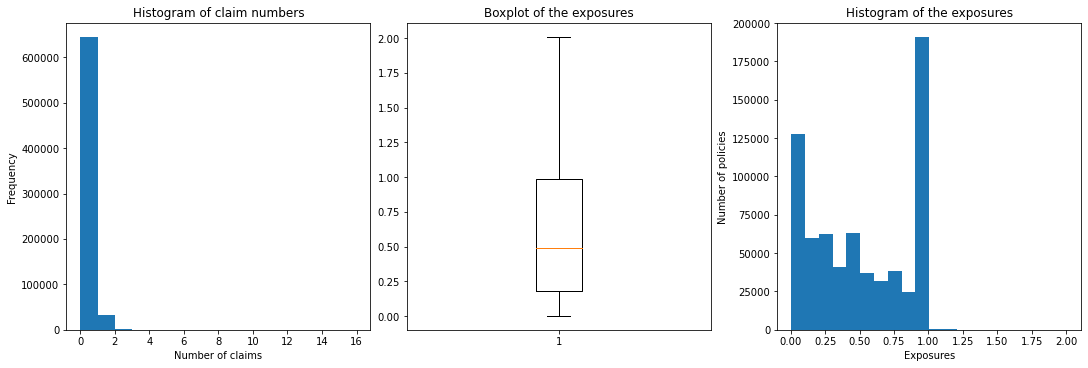

In [152]:
fig = plt.figure(figsize = (15, 5), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
ax1.hist(df['ClaimNb'], bins = 16)
ax1.set_xlabel('Number of claims')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of claim numbers')

ax2 = fig.add_subplot(spec[0, 1])
ax2.boxplot(df['Exposure'])
ax2.set_title('Boxplot of the exposures')

ax3 = fig.add_subplot(spec[0, 2])
ax3.hist(df['Exposure'], bins = 20)
ax3.set_xlabel('Exposures')
ax3.set_ylabel('Number of policies')
ax3.set_title('Histogram of the exposures')

In [153]:
# Number of policies corresponding to number of claims
df.groupby('ClaimNb')['ClaimNb'].count()

ClaimNb
0.0     643953
1.0      32178
2.0       1784
3.0         82
4.0          7
5.0          2
6.0          1
8.0          1
9.0          1
11.0         3
16.0         1
Name: ClaimNb, dtype: int64

From these statistics, we observe for the number of claims that 9 policies have more than 4 claims, the maximal number of claims being 16 as shown above. According to the tutorial these entries are most probably errors and therefore were corrected by setting them equal to 4, however in this notebook we will keep these entries as they are.  Additionally we have many exposures that are less than 1 year-at-risk, the smallest exposure is 1 day and the biggest exposure are 2 years.

In [154]:
total_exposures = pd.DataFrame(df.groupby('ClaimNb')['Exposure'].sum()).rename(columns = {'Exposure':'Total exposures'})
number_policies = pd.DataFrame(df.groupby('ClaimNb')['Exposure'].count()).rename(columns = {'Exposure':'Number of policies'})
claim_portfolio = total_exposures.join(number_policies)
claim_portfolio.index.names = ['Number of claims']
claim_portfolio.T.round(decimals = 1)

Number of claims,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,9.0,11.0,16.0
Total exposures,336616.1,20670.8,1153.4,52.8,3.1,1.1,0.3,0.4,0.1,1.2,0.3
Number of policies,643953.0,32178.0,1784.0,82.0,7.0,2.0,1.0,1.0,1.0,3.0,1.0


(-1.0, 19.5)

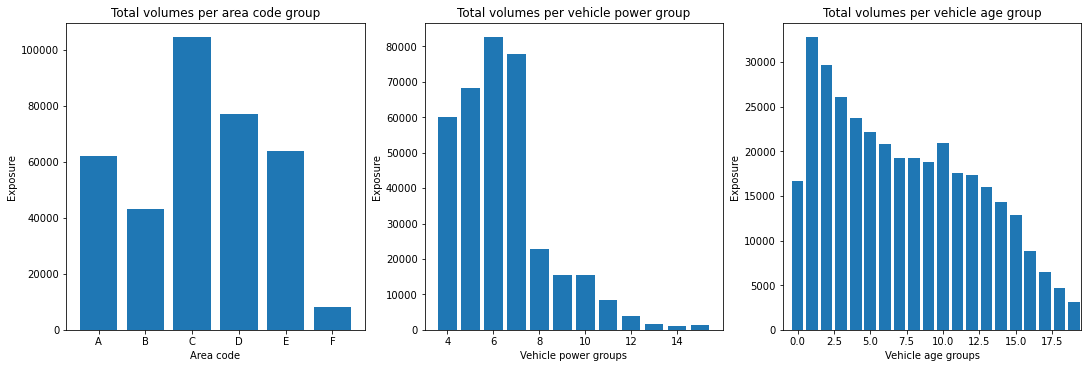

In [155]:
df_area = df[['Area', 'Exposure', 'ClaimNb']].groupby('Area', as_index = False).sum()
df_area_mean = df[['Area', 'Exposure', 'ClaimNb']].groupby('Area', as_index = False).mean()
df_vpow = df[['VehPower', 'Exposure', 'ClaimNb']].groupby('VehPower', as_index = False).sum()
df_vpow_mean = df[['VehPower', 'Exposure', 'ClaimNb']].groupby('VehPower', as_index = False).mean()
df_vage = df[['VehAge', 'Exposure', 'ClaimNb']].groupby('VehAge', as_index = False).sum()
df_vage_mean = df[['VehAge', 'Exposure', 'ClaimNb']].groupby('VehAge', as_index = False).mean()

fig2 = plt.figure(figsize = (15, 5), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig2)

ax1 = fig2.add_subplot(spec2[0, 0])
ax1.bar(df_area['Area'], df_area['Exposure'])
ax1.set_xlabel('Area code')
ax1.set_ylabel('Exposure')
ax1.set_title('Total volumes per area code group')

ax2 = fig2.add_subplot(spec2[0, 1])
ax2.bar(df_vpow['VehPower'], df_vpow['Exposure'])
ax2.set_xlabel('Vehicle power groups')
ax2.set_ylabel('Exposure')
ax2.set_title('Total volumes per vehicle power group')

ax3 = fig2.add_subplot(spec2[0, 2])
ax3.bar(df_vage['VehAge'], df_vage['Exposure'])
ax3.set_xlabel('Vehicle age groups')
ax3.set_ylabel('Exposure')
ax3.set_title('Total volumes per vehicle age group')
ax3.set_xlim([-1, 19.5])

Text(0.5, 1.0, 'Observed frequency per vehicle age groups')

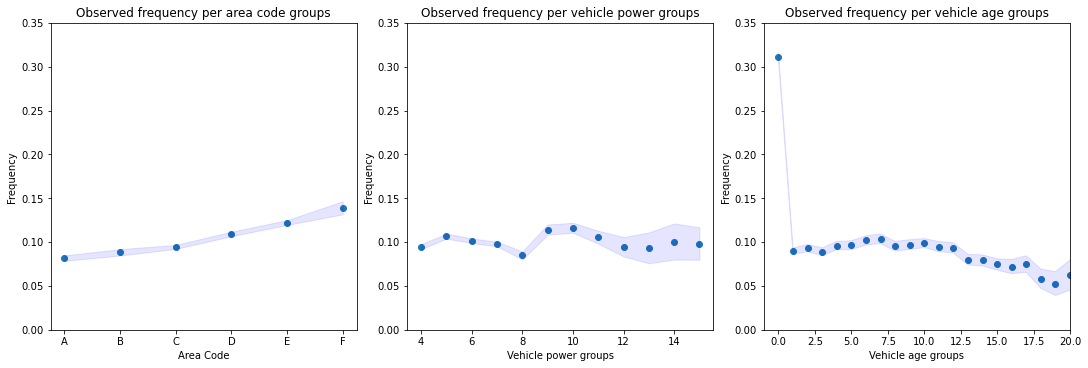

In [156]:
fig3 = plt.figure(figsize = (15, 5), constrained_layout=True)
spec3 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig3)

ax1 = fig3.add_subplot(spec3[0, 0])
x=df_area['Area']
y=df_area['ClaimNb']/df_area['Exposure']
y_mean = df_area_mean['ClaimNb']
ax1.scatter(x, y)
ax1.fill_between(x, (y-np.sqrt(y_mean/df_area['ClaimNb'])), (y+np.sqrt(y_mean/df_area['ClaimNb'])), color='b', alpha=.1)
ax1.set_ylim([0, 0.35])
ax1.set_xlabel('Area Code')
ax1.set_ylabel('Frequency')
ax1.set_title('Observed frequency per area code groups')

ax2 = fig3.add_subplot(spec3[0, 1])
x=df_vpow['VehPower']
y=df_vpow['ClaimNb']/df_vpow['Exposure']
y_mean = df_vpow_mean['ClaimNb']
ax2.scatter(x, y)
ax2.fill_between(x, (y-np.sqrt(y_mean/df_vpow['ClaimNb'])), (y+np.sqrt(y_mean/df_vpow['ClaimNb'])), color='b', alpha=.1)
ax2.set_ylim([0, 0.35])
ax2.set_xlabel('Vehicle power groups')
ax2.set_ylabel('Frequency')
ax2.set_title('Observed frequency per vehicle power groups')

ax3 = fig3.add_subplot(spec3[0, 2])
x=df_vage['VehAge']
y=df_vage['ClaimNb']/df_vage['Exposure']
y_mean = df_vage_mean['ClaimNb']
ax3.scatter(x, y)
ax3.fill_between(x, (y-np.sqrt(y_mean/df_vage['ClaimNb'])), (y+np.sqrt(y_mean/df_vage['ClaimNb'])), color='b', alpha=.1)
ax3.set_ylim([0, 0.35])
ax3.set_xlim([-1, 20])
ax3.set_xlabel('Vehicle age groups')
ax3.set_ylabel('Frequency')
ax3.set_title('Observed frequency per vehicle age groups')

### Geospatial Visualization of Features

In [157]:
# Load region geometries
france = gpd.read_file('data/regions-avant-redecoupage-2015.geojson')
france = france.rename(columns = {'nom':'Region', 'code':'Code'})
france['Code'] = france['Code'].astype(int)
france.head()

,Region,Code,geometry
0,Île-de-France,11,"POLYGON ((2.59052 49.07966, 2.60913 49.09156, 2.61034 49.09494, 2...."
1,Champagne-Ardenne,21,"POLYGON ((4.04797 49.40564, 4.04913 49.40901, 4.04326 49.42460, 4...."
2,Picardie,22,"POLYGON ((3.48519 48.85191, 3.48016 48.85160, 3.47020 48.85055, 3...."
3,Haute-Normandie,23,"POLYGON ((0.81482 48.67017, 0.81018 48.67135, 0.79648 48.67491, 0...."
4,Centre,24,"POLYGON ((2.28105 46.42041, 2.27628 46.42128, 2.25696 46.42313, 2...."


The corresponding geojson file was taken from Grégoire David's GitHub repository:  https://github.com/gregoiredavid/france-geojson/blob/master/regions-avant-redecoupage-2015.geojson

In [158]:
# Group dataset by 'Region' and calculate mean values
df_copy = df.copy()
df_copy['Area'] = df_copy['Area'].replace(['A', 'B', 'C', 'D', 'E', 'F'], [1, 2, 3, 4, 5, 6]).astype(int)
df_copy = df_copy.groupby('Region', as_index = False).mean()
df_copy['Region'] = df_copy['Region'].apply(lambda x: x.replace('R', '')).astype(int)
france = france.join(df_copy[['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']])

In contrast to the tutorial, the features `VehAge`, `DrivAge` and `BonusMalus` were considered here in their original form (not capped) for their corresponding visualization.

* **Regions of France before 2016**

In [159]:
france.explore("Region", legend = True)

* **Mean Values of Area Code and Vehicle Power per Region**

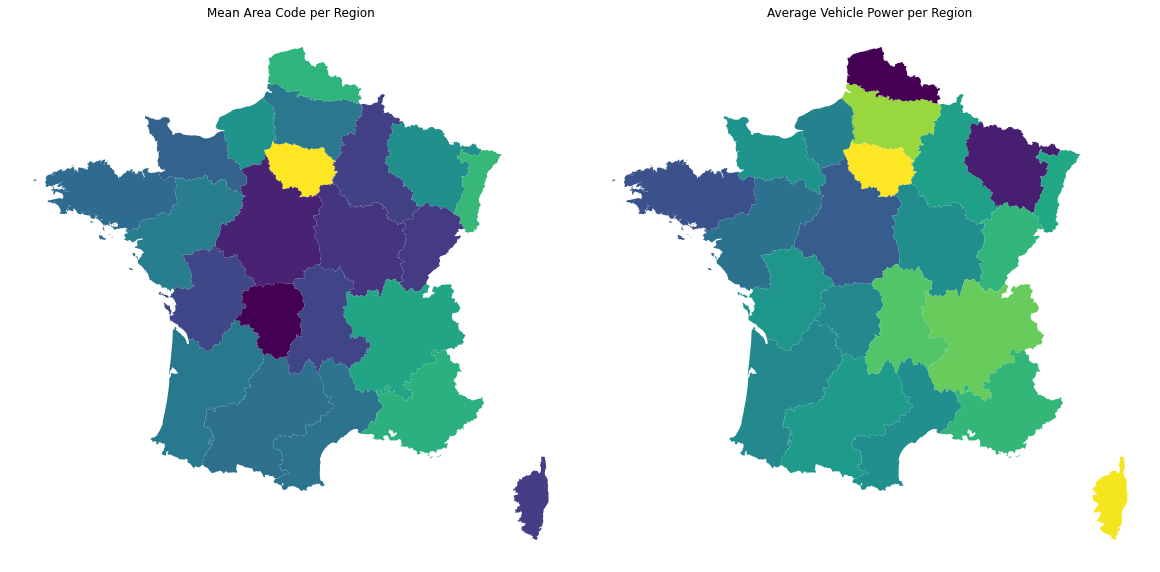

In [160]:
fig, ax = plt.subplots(1, 2, figsize = (16,12), sharex=True, sharey=True, constrained_layout = True)
france.plot(ax=ax[0], column='Area', legend = False, cmap = 'viridis')
ax[0].set_title('Mean Area Code per Region')
ax[0].set_axis_off()
france.plot(ax=ax[1], column='VehPower', legend = False)
ax[1].set_title('Average Vehicle Power per Region')
ax[1].set_axis_off()

We can see that *Île-de-France* (Paris) has in average the highest area code whereas the central regions of France including *Corsica* have the lowest ones. Additionally policy holders with the most powerful vehicles are located in *Île-de-France* and *Corsica* as well.

* **Mean Values of Vehicle Age and Driver Age per Region**

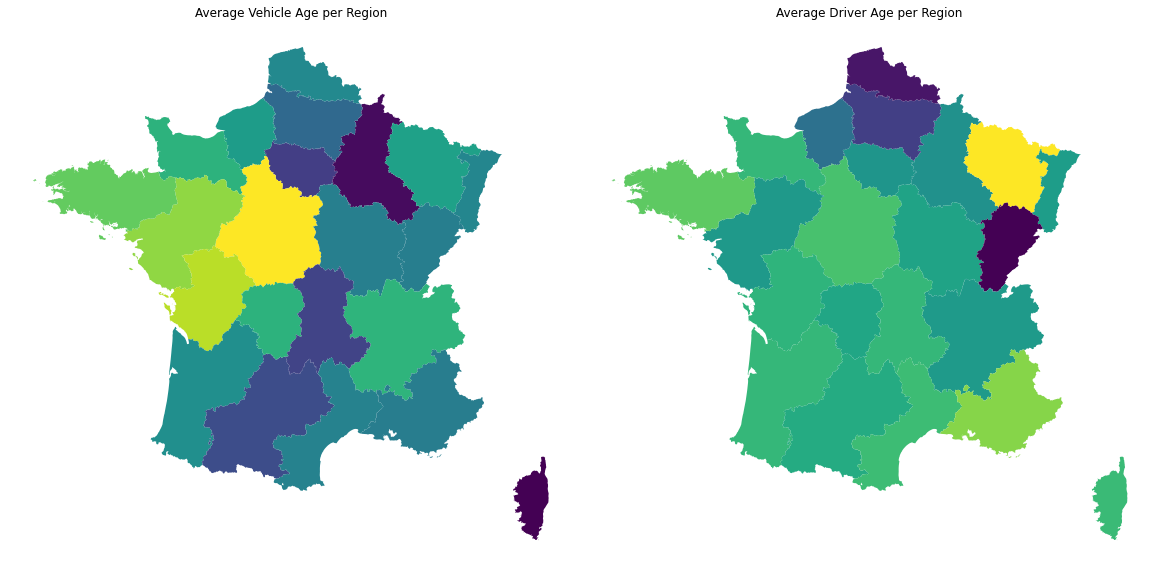

In [161]:
fig, ax = plt.subplots(1, 2, figsize = (16,12), sharex=True, sharey=True, constrained_layout = True)
france.plot(ax=ax[0], column='VehAge', legend = False)
ax[0].set_title('Average Vehicle Age per Region')
ax[0].set_axis_off()
france.plot(ax=ax[1], column='DrivAge', legend = False)
ax[1].set_title('Average Driver Age per Region')
ax[1].set_axis_off()

It is interesting to see that policy holders in *Corsica* not only have powerful vehicles but also the newest ones together with clients from *Champagne-Ardenne*.  In contrast the oldest drivers are located in *Lorraine* where some of the least powerful vehicles are located.  However the youngest drivers which are located in *Nord-Pas-de-Calais* also drive the least powerful vehicles.

<a id="GLM"></a>

# Generalized Linear Models (GLM)

## GLM with statsmodels

* **Data Preprocessing**

In [162]:
df_glm = df.copy()

In [163]:
# Area: we choose a continuous (log-linear) feature component for {A, . . . , F} → {1, . . . , 6}
df_glm['AreaGLM'] = df_glm['Area'].replace(['A', 'B', 'C', 'D', 'E', 'F'], [1, 2, 3, 4, 5, 6])
df_glm['AreaGLM'] = df_glm['AreaGLM'].astype(int)
df_glm['AreaGLM'].unique()

array([4, 2, 5, 3, 6, 1])

In [164]:
# VehPower: we choose a categorical feature component where we merge vehicle power groups
# bigger and equal to 9 (totally 6 classes)
df_glm['VehPowerGLM'] = df_glm['VehPower'].apply(lambda x: 9 if x >= 9 else x).astype(int)
df_glm['VehPowerGLM'] = df_glm['VehPowerGLM'].astype('category')
df_glm['VehPowerGLM'].unique()

[5, 6, 7, 4, 9, 8]
Categories (6, int64): [4, 5, 6, 7, 8, 9]

In [165]:
# VehAge: we build 3 categorical classes [0, 1), [1, 10], (10, ∞)
df_glm['VehAgeGLM'] = df_glm['VehAge'].values
df_glm['VehAgeGLM'] = df_glm['VehAgeGLM'].apply(lambda x: 1 if x < 1 else (2 if (x >= 1 and x <= 10) else (3 if x > 10 else x)))
df_glm['VehAgeGLM'] = df_glm['VehAgeGLM'].astype('category')
df_glm['VehAgeGLM'].unique()

[1, 2, 3]
Categories (3, int64): [1, 2, 3]

In [166]:
# DrivAge: we build 7 categorical classes [18, 21), [21, 26), [26, 31), [31, 41), [41, 51), [51, 71), [71, ∞)
df_glm['DrivAgeGLM'] = df_glm['DrivAge'].values
df_glm['DrivAgeGLM'] = df_glm['DrivAgeGLM'].apply(lambda x: 1 if x < 21 
                                                else (2 if (x >= 21 and x < 26) 
                                                else (3 if (x >= 26 and x < 31)
                                                else (4 if (x >= 31 and x < 41)
                                                else (5 if (x >= 41 and x < 51)
                                                else (6 if (x >= 51 and x < 71)
                                                else (7 if x >= 71 else x)))))))
df_glm['DrivAgeGLM'] = df_glm['DrivAgeGLM'].astype('category')
df_glm['DrivAgeGLM'].unique()

[6, 5, 4, 3, 2, 7, 1]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [167]:
# BonusMalus: continuous log-linear feature component (we cap at value 150)
df_glm['BonusMalusGLM'] = df_glm['BonusMalus'].clip(upper = 150)
df_glm['BonusMalusGLM'].unique()

array([ 50.,  68.,  90., 100.,  76.,  56.,  71.,  52.,  85.,  51.,  54.,
        80.,  66.,  72.,  55.,  53.,  60.,  95.,  64.,  57.,  58.,  91.,
        62.,  97.,  74.,  61.,  63., 105., 106.,  88.,  67.,  86.,  75.,
        59.,  77., 118.,  73., 125.,  70., 120.,  69.,  78.,  82., 112.,
        65.,  81., 115.,  93.,  83.,  84.,  92., 101., 109., 110.,  79.,
       102., 140., 147., 150., 108.,  96., 107., 132., 148.,  87., 116.,
       114., 139., 119., 103., 122., 128., 133.,  89., 113.,  99., 126.,
       111., 149., 117., 138., 104.,  94., 136.,  98., 135., 142., 144.,
       121., 141., 130., 123., 124.])

In [168]:
# Density: log-density is chosen as continuous log-linear feature component (note that we
# have very small volumes for small log-densities)
df_glm['DensityGLM'] = df_glm['Density'].apply(np.log)
df_glm['DensityGLM']

0         7.104144
1         7.104144
2         3.988984
3         4.330733
4         4.330733
            ...   
678008    8.106816
678009    9.195227
678010    7.187657
678011    4.553877
678012    4.174387
Name: DensityGLM, Length: 678013, dtype: float64

In [169]:
df_glm.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,4,5,1,6,50.0,7.104144
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,4,5,1,6,50.0,7.104144
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,2,6,2,6,50.0,3.988984
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,2,7,1,5,50.0,4.330733
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,2,7,1,5,50.0,4.330733


In [170]:
Train, Test = train_test_split(df_glm, test_size = 0.1, random_state = 100)

In [171]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610211 entries, 130141 to 56088
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IDpol          610211 non-null  float64 
 1   ClaimNb        610211 non-null  float64 
 2   Exposure       610211 non-null  float64 
 3   Area           610211 non-null  category
 4   VehPower       610211 non-null  float64 
 5   VehAge         610211 non-null  float64 
 6   DrivAge        610211 non-null  float64 
 7   BonusMalus     610211 non-null  float64 
 8   VehBrand       610211 non-null  category
 9   VehGas         610211 non-null  object  
 10  Density        610211 non-null  float64 
 11  Region         610211 non-null  category
 12  AreaGLM        610211 non-null  int32   
 13  VehPowerGLM    610211 non-null  category
 14  VehAgeGLM      610211 non-null  category
 15  DrivAgeGLM     610211 non-null  category
 16  BonusMalusGLM  610211 non-null  float64 
 17  Densit

In [172]:
Train.shape
Test.shape

(67802, 18)

* **Model Training**

In [173]:
%%time
glm1 = smf.glm(formula = '''ClaimNb ~ VehPowerGLM 
                           + C(VehAgeGLM, Treatment(reference = 2)) 
                           + C(DrivAgeGLM, Treatment(reference = 5)) 
                           + BonusMalusGLM 
                           + C(VehBrand) 
                           + C(VehGas) 
                           + DensityGLM 
                           + C(Region, Treatment(reference = 'R24')) 
                           + AreaGLM''', 
                           family = sm.families.Poisson(), 
                           data = Train, 
                           exposure = np.asarray(Train['Exposure']))

glm1 = glm1.fit()

CPU times: total: 32.1 s
Wall time: 36.8 s


In [174]:
print(glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610211
Model:                            GLM   Df Residuals:                   610162
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2706e+05
Date:                Mon, 06 Jun 2022   Deviance:                   1.9185e+05
Time:                        23:19:54   Pearson chi2:                 1.43e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01662
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

* **Results**

In [175]:
y_pred_train = glm1.predict(Train, exposure=Train['Exposure'])
y_pred_train = np.array(y_pred_train)
y_true_train = np.array(Train['ClaimNb'])
loss_glm_train = mean_poisson_deviance(y_true_train, y_pred_train)

y_pred_test = glm1.predict(Test, exposure=Test['Exposure'])
y_pred_test = np.array(y_pred_test)
y_true_test = np.array(Test['ClaimNb'])
loss_glm_test = mean_poisson_deviance(y_true_test, y_pred_test)

In [176]:
print('In-sample loss')
print('Mean Poisson Deviance: ' + str(loss_glm_train))
print('Mean Poisson Deviance calculated as Deviance/No. of observations: ' + str(glm1.deviance/Train.shape[0]))
print('Out-of-sample loss')
print('Mean Poisson Deviance: ' + str(loss_glm_test))

In-sample loss
Mean Poisson Deviance: 0.3144044053328455
Mean Poisson Deviance calculated as Deviance/No. of observations: 0.3144044053328455
Out-of-sample loss
Mean Poisson Deviance: 0.3149990366236818


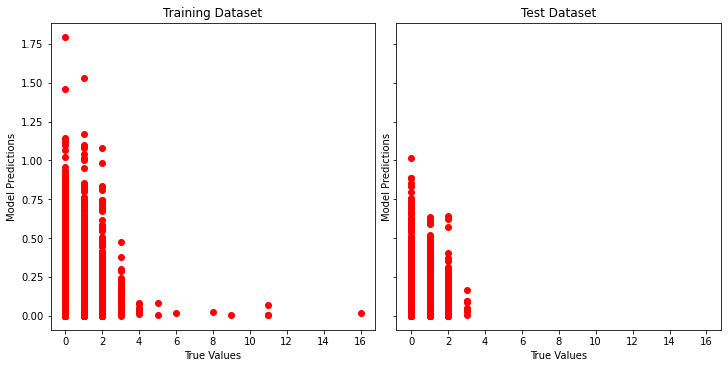

In [177]:
plot_results(y_true_train, y_pred_train, y_true_test, y_pred_test)

## GLM with H2O

In [178]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 10 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,2 years and 5 days !!!
H2O_cluster_name:,H2O_from_python_eduar_vnxjwr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.771 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


* **Data Preprocessing**

In [179]:
Train_h2o = Train.copy()
Train_h2o['log_Exposure'] = Train['Exposure'].apply(np.log)
Train_h2o = h2o.H2OFrame(Train_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [180]:
Test_h2o = Test.copy()
Test_h2o['log_Exposure'] = Test['Exposure'].apply(np.log)
Test_h2o = h2o.H2OFrame(Test_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [181]:
Train_h2o['VehPowerGLM'] = Train_h2o['VehPowerGLM'].asfactor()
Train_h2o['VehAgeGLM'] = Train_h2o['VehAgeGLM'].asfactor()
Train_h2o['VehAgeGLM'].relevel('2')
Train_h2o['DrivAgeGLM'] = Train_h2o['DrivAgeGLM'].asfactor()
Train_h2o['DrivAgeGLM'].relevel('5')

allLevels = Train_h2o.levels()

print('Levels contained in dataframe:\n')
print(allLevels)

# VehAge
Train_h2o[14] = Train_h2o[14].relevel(allLevels[14][1])
# DrivAge
Train_h2o[15] = Train_h2o[15].relevel(allLevels[15][4])
# Region
Train_h2o[11] = Train_h2o[11].relevel(allLevels[11][4])

Levels contained in dataframe:

[[], [], [], ['A', 'B', 'C', 'D', 'E', 'F'], [], [], [], [], ['B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B2', 'B3', 'B4', 'B5', 'B6'], ['Diesel', 'Regular'], [], ['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41', 'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82', 'R83', 'R91', 'R93', 'R94'], [], ['4', '5', '6', '7', '8', '9'], ['1', '2', '3'], ['1', '2', '3', '4', '5', '6', '7'], [], [], []]


In [182]:
Test_h2o['VehPowerGLM'] = Test_h2o['VehPowerGLM'].asfactor()
Test_h2o['VehAgeGLM'] = Test_h2o['VehAgeGLM'].asfactor()
Test_h2o['VehAgeGLM'].relevel('2')
Test_h2o['DrivAgeGLM'] = Test_h2o['DrivAgeGLM'].asfactor()
Test_h2o['DrivAgeGLM'].relevel('5')

allLevels = Test_h2o.levels()

print('Levels contained in dataframe:\n')
print(allLevels)

# VehAge
Test_h2o[14] = Test_h2o[14].relevel(allLevels[14][1])
# DrivAge
Test_h2o[15] = Test_h2o[15].relevel(allLevels[15][4])
# Region
Test_h2o[11] = Test_h2o[11].relevel(allLevels[11][4])

Levels contained in dataframe:

[[], [], [], ['A', 'B', 'C', 'D', 'E', 'F'], [], [], [], [], ['B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B2', 'B3', 'B4', 'B5', 'B6'], ['Diesel', 'Regular'], [], ['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41', 'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82', 'R83', 'R91', 'R93', 'R94'], [], ['4', '5', '6', '7', '8', '9'], ['1', '2', '3'], ['1', '2', '3', '4', '5', '6', '7'], [], [], []]


In [183]:
predictors = ['VehPowerGLM', 'VehAgeGLM', 'DrivAgeGLM', 'BonusMalusGLM', 'VehBrand', 'VehGas', 'DensityGLM', 'Region', 'AreaGLM']
response = 'ClaimNb'

* **Model training**

In [184]:
%%time
glm1_h2o = H2OGeneralizedLinearEstimator(family= "poisson",
                                         lambda_ = 0,
                                         compute_p_values = True,
                                         offset_column = 'log_Exposure',
                                         seed = 100)

glm1_h2o.train(predictors, response, training_frame = Train_h2o)

glm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: total: 78.1 ms
Wall time: 10.4 s


In [185]:
glm1_h2o._model_json['output']['model_summary']


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,poisson,log,None,48,48,4,py_53_sid_affe


In [186]:
glm_results = glm1_h2o._model_json['output']['coefficients_table'].as_data_frame()
glm_results.sort_values(by = 'p_value', ascending = True, inplace = True)
glm_results

,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,-3.990078,0.038601,-103.368238,0.000000e+00,-2.372830
44,VehAgeGLM.3,-0.194622,0.014075,-13.827899,0.000000e+00,-0.194622
43,VehAgeGLM.1,1.170813,0.017131,68.344464,0.000000e+00,1.170813
42,VehPowerGLM.9,0.199716,0.021111,9.460331,0.000000e+00,0.199716
39,VehPowerGLM.6,0.220930,0.019085,11.575790,0.000000e+00,0.220930
38,VehPowerGLM.5,0.188495,0.019186,9.824765,0.000000e+00,0.188495
35,DrivAgeGLM.4,-0.297717,0.016644,-17.887299,0.000000e+00,-0.297717
34,DrivAgeGLM.3,-0.426543,0.023099,-18.465648,0.000000e+00,-0.426543
33,DrivAgeGLM.2,-0.319334,0.027925,-11.435493,0.000000e+00,-0.319334
47,BonusMalusGLM,0.023098,0.000356,64.952347,0.000000e+00,0.360769


In [187]:
glm1_h2o._model_json['output']['training_metrics']


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.057112940834523555
RMSE: 0.23898313922643907
MAE: 0.09821949128504794
RMSLE: 0.15911588531579146
R^2: 0.010061764651296823
Mean Residual Deviance: 0.314404405332846
Null degrees of freedom: 610210
Residual degrees of freedom: 610162
Null deviance: 202082.2856376308
Residual deviance: 191853.02658256132
AIC: 254212.89495426256


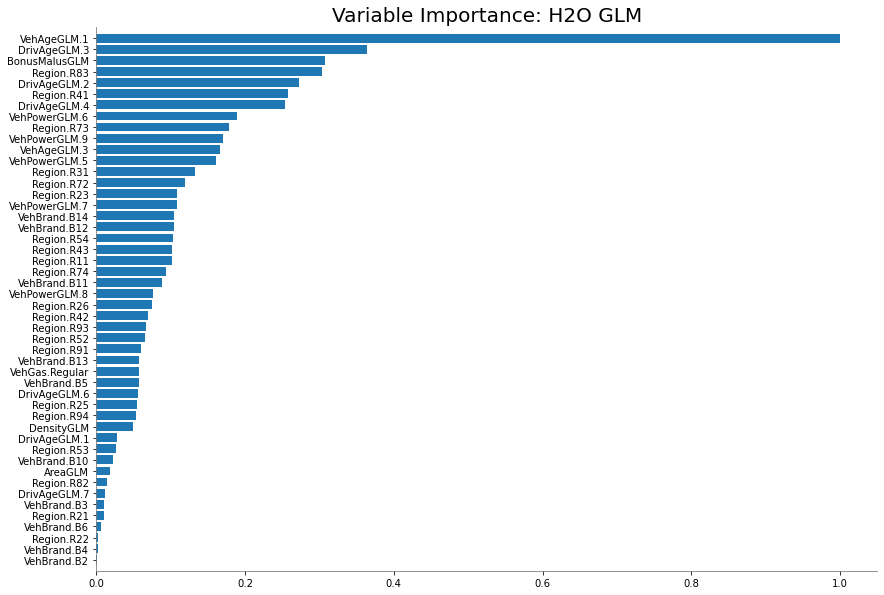

In [188]:
glm1_h2o.varimp_plot(num_of_features = 48)

* **Results**

In [189]:
y_pred_h2o_train = glm1_h2o.predict(Train_h2o)
y_pred_h2o_train = np.array(h2o.as_list(y_pred_h2o_train['predict']))
y_true_train=np.array(h2o.as_list(Train_h2o['ClaimNb']))
loss_glm_h2o_train = mean_poisson_deviance(y_true_train, y_pred_h2o_train)

y_pred_h2o_test = glm1_h2o.predict(Test_h2o)
y_pred_h2o_test = np.array(h2o.as_list(y_pred_h2o_test['predict']))
y_true_test=np.array(h2o.as_list(Test_h2o['ClaimNb']))
loss_glm_h2o_test = mean_poisson_deviance(y_true_test, y_pred_h2o_test)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [190]:
print('In-sample loss')
print('Mean Poisson Deviance: ' + str(loss_glm_h2o_train))
print('Out-of-sample loss')
print('Mean Poisson Deviance: ' + str(loss_glm_h2o_test))

In-sample loss
Mean Poisson Deviance: 0.31440440533284575
Out-of-sample loss
Mean Poisson Deviance: 0.3149990365697425


<a id="RT"></a>

# Regression Trees

## Gradient Boosting Machine with H2O

* **Data Preprocessing**

In [191]:
Train_DT, Test_DT = train_test_split(df, test_size = 0.1, random_state = 100)

labeler = OrdinalEncoder()

Train_DT.drop('IDpol', axis = 1, inplace = True)

# Using .fit_transform function to fit label
# encoder and return encoded label

label = labeler.fit_transform(Train_DT['Area'].array.reshape(-1,1))
Train_DT.drop('Area', axis = 1, inplace = True)
Train_DT['Area'] = label

label = labeler.fit_transform(Train_DT['VehBrand'].array.reshape(-1,1))
Train_DT.drop('VehBrand', axis = 1, inplace = True)
Train_DT['VehBrand'] = label

label = labeler.fit_transform(Train_DT['VehGas'].array.reshape(-1,1))
Train_DT.drop('VehGas', axis = 1, inplace = True)
Train_DT['VehGas'] = label

label = labeler.fit_transform(Train_DT['Region'].array.reshape(-1,1))
Train_DT.drop('Region', axis = 1, inplace = True)
Train_DT['Region'] = label

Train_DT['Frequency'] = Train_DT['ClaimNb']/Train_DT['Exposure']

Train_DT['logExposure'] = Train_DT['Exposure'].apply(np.log)

#Train_DT.head()

Test_DT.drop('IDpol', axis = 1, inplace = True)

# Using .fit_transform function to fit label
# encoder and return encoded label

label = labeler.fit_transform(Test_DT['Area'].array.reshape(-1,1))
Test_DT.drop('Area', axis = 1, inplace = True)
Test_DT['Area'] = label

label = labeler.fit_transform(Test_DT['VehBrand'].array.reshape(-1,1))
Test_DT.drop('VehBrand', axis = 1, inplace = True)
Test_DT['VehBrand'] = label

label = labeler.fit_transform(Test_DT['VehGas'].array.reshape(-1,1))
Test_DT.drop('VehGas', axis = 1, inplace = True)
Test_DT['VehGas'] = label

label = labeler.fit_transform(Test_DT['Region'].array.reshape(-1,1))
Test_DT.drop('Region', axis = 1, inplace = True)
Test_DT['Region'] = label

Test_DT['Frequency'] = Test_DT['ClaimNb']/Test_DT['Exposure']

Test_DT['logExposure'] = Test_DT['Exposure'].apply(np.log)


In [192]:
Train_DT.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region,Frequency,logExposure
130141,0.0,0.21,9.0,2.0,44.0,50.0,27000.0,5.0,1.0,1.0,0.0,0.0,-1.560648
302816,0.0,0.49,10.0,5.0,45.0,50.0,27000.0,5.0,1.0,0.0,0.0,0.0,-0.713350
341828,0.0,0.51,6.0,4.0,52.0,50.0,483.0,2.0,3.0,1.0,19.0,0.0,-0.673345
75882,0.0,0.26,7.0,1.0,58.0,50.0,405.0,2.0,0.0,1.0,4.0,0.0,-1.347074
157978,0.0,0.15,4.0,4.0,79.0,50.0,3386.0,4.0,4.0,1.0,12.0,0.0,-1.897120


* **Model Training**

In [193]:
%%time
# Build and train the model:
gbm_h2o = H2OGradientBoostingEstimator(nfolds=0,
                                       seed=100,
                                       #keep_cross_validation_predictions = True, 
                                       min_rows = 10000,
                                       distribution = 'poisson',
                                       offset_column = 'logExposure',
                                       max_depth = 1,
                                       #categorical_encoding = 'OneHotExplicit',
                                       ntrees = 30)

predictors = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area', 'VehBrand', 'VehGas', 'Region']
response = 'ClaimNb'

gbm_h2o.train(x=predictors, y=response, training_frame=h2o.H2OFrame(Train_DT))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: total: 5.91 s
Wall time: 26 s


In [194]:
gbm_h2o

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1654546153393_6


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,2510.0,1.0,1.0,1.0,2.0,2.0,2.0




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.05713115166039783
RMSE: 0.2390212368397374
MAE: 0.09855234379404082
RMSLE: 0.15876821510225803
Mean Residual Deviance: 0.4152096377879627

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-06-06 23:23:01,0.000 sec,0.0,0.240501,0.099840,0.428655
1,,2022-06-06 23:23:01,0.164 sec,1.0,0.240406,0.099596,0.427393
2,,2022-06-06 23:23:01,0.296 sec,2.0,0.240324,0.099405,0.426328
3,,2022-06-06 23:23:01,0.399 sec,3.0,0.240256,0.099258,0.425433
4,,2022-06-06 23:23:01,0.511 sec,4.0,0.240110,0.099075,0.424502
5,,2022-06-06 23:23:01,0.650 sec,5.0,0.240055,0.098979,0.423752
6,,2022-06-06 23:23:01,0.766 sec,6.0,0.239962,0.098900,0.423083
7,,2022-06-06 23:23:01,0.879 sec,7.0,0.239844,0.098785,0.422353
8,,2022-06-06 23:23:02,0.987 sec,8.0,0.239802,0.098731,0.421726
9,,2022-06-06 23:23:02,1.097 sec,9.0,0.239720,0.098689,0.421199



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,VehAge,1350.870361,1.000000,0.508238
1,BonusMalus,1307.078003,0.967582,0.491762
2,VehPower,0.000000,0.000000,0.000000
3,DrivAge,0.000000,0.000000,0.000000
4,Density,0.000000,0.000000,0.000000
5,Area,0.000000,0.000000,0.000000
6,VehBrand,0.000000,0.000000,0.000000
7,VehGas,0.000000,0.000000,0.000000
8,Region,0.000000,0.000000,0.000000


* **Results**

In [195]:
# Generate predictions on a test set (if necessary):
y_pred_h2o_train = gbm_h2o.predict(h2o.H2OFrame(Train_DT))
y_pred_h2o_train = np.array(h2o.as_list(y_pred_h2o_train))
y_true_train=np.array(Train_DT['ClaimNb'])

loss_gbm_h2o_train = mean_poisson_deviance(y_true_train, y_pred_h2o_train)

y_pred_h2o_test = gbm_h2o.predict(h2o.H2OFrame(Test_DT))
y_pred_h2o_test = np.array(h2o.as_list(y_pred_h2o_test))
y_true_test=np.array(Test_DT['ClaimNb'])

loss_gbm_h2o_train = mean_poisson_deviance(y_true_test, y_pred_h2o_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [196]:
print('In-sample loss')
print('Mean Poisson Deviance: ' + str(loss_gbm_h2o_train))
print('Out-of-sample loss')
print('Mean Poisson Deviance: ' + str(loss_glm_h2o_test))

In-sample loss
Mean Poisson Deviance: 0.3175946220251143
Out-of-sample loss
Mean Poisson Deviance: 0.3149990365697425


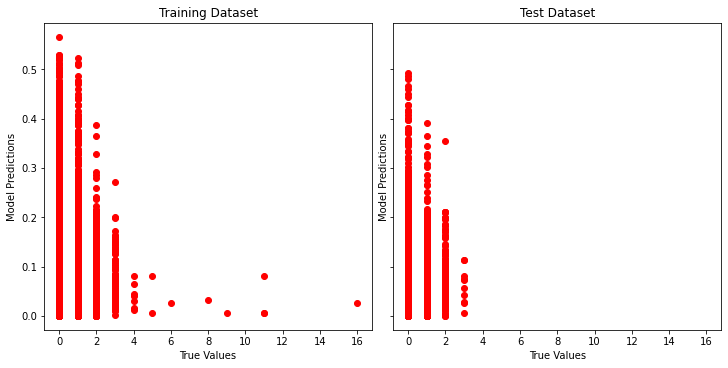

In [197]:
plot_results(y_true_train, y_pred_h2o_train, y_true_test, y_pred_h2o_test)

<a id="ANN"></a>

# Artificial Neural Networks

* **Data Preprocessing**

In [198]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('IDpol', axis = 1), df['ClaimNb'], test_size = 0.1, random_state = 100)
X_train.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
130141,0.0,0.21,F,9.0,2.0,44.0,50.0,B10,Regular,27000.0,R11
302816,0.0,0.49,F,10.0,5.0,45.0,50.0,B10,Diesel,27000.0,R11
341828,0.0,0.51,C,6.0,4.0,52.0,50.0,B12,Regular,483.0,R91
75882,0.0,0.26,C,7.0,1.0,58.0,50.0,B1,Regular,405.0,R24
157978,0.0,0.15,E,4.0,4.0,79.0,50.0,B13,Regular,3386.0,R53


In [199]:
column_trans = ColumnTransformer([('onehot', OneHotEncoder(), ['Area', 'VehBrand', 'Region']),
                                  ('onehot_vehgas', OneHotEncoder(drop = 'if_binary'), ['VehGas'])],
                                  remainder=MinMaxScaler())

X_train_scaled = column_trans.fit_transform(X_train)
X_train_scaled = X_train_scaled.toarray()
print(X_train_scaled.shape)
X_test_scaled = column_trans.transform(X_test)
print(X_test_scaled.shape)

(610211, 47)
(67802, 47)


In [200]:
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
print(y_train_scaled.shape)
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
print(y_test_scaled.shape)

(610211, 1)
(67802, 1)


* **Shallow Network Architecture**

In [201]:
tf.keras.backend.clear_session()

In [202]:
ann = keras.Sequential()
ann.add(Dense(20, input_shape=(47,), kernel_initializer = GlorotUniform(seed=100)))
ann.add(Activation('sigmoid'))
ann.add(Dense(1))
ann.compile(loss = 'mae', optimizer = 'adam')
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                960       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


* **Model Training**

In [203]:
%%time
epochs_hist = ann.fit(X_train_scaled, y_train_scaled, epochs = 1, batch_size = 200, validation_split = 0.2)

2441/2441 [==============================] - 4s 1ms/step - loss: 0.0040 - val_loss: 0.0011
CPU times: total: 4.89 s
Wall time: 4.32 s


* **Results**

In [204]:
constant = 0.000001
zero_offset = lambda t: t + constant if t == 0 else t

y_pred_train_scaled = ann.predict(X_train_scaled)
y_pred_train = target_scaler.inverse_transform(y_pred_train_scaled)
loss_ann_train = mean_poisson_deviance(y_train, np.abs(list(map(zero_offset, y_pred_train))))

y_pred_test_scaled = ann.predict(X_test_scaled)
y_pred_test = target_scaler.inverse_transform(y_pred_test_scaled)
loss_ann_test = mean_poisson_deviance(y_test, np.abs(list(map(zero_offset, y_pred_test))))

2119/2119 [==============================] - 2s 1ms/step


In [205]:
print('In-sample loss')
print('Mean Poisson Deviance: ' + str(loss_ann_train))
print('Out-of-sample loss')
print('Mean Poisson Deviance: ' + str(loss_ann_test))

In-sample loss
Mean Poisson Deviance: 0.03217315770948581
Out-of-sample loss
Mean Poisson Deviance: 0.03224805744530558


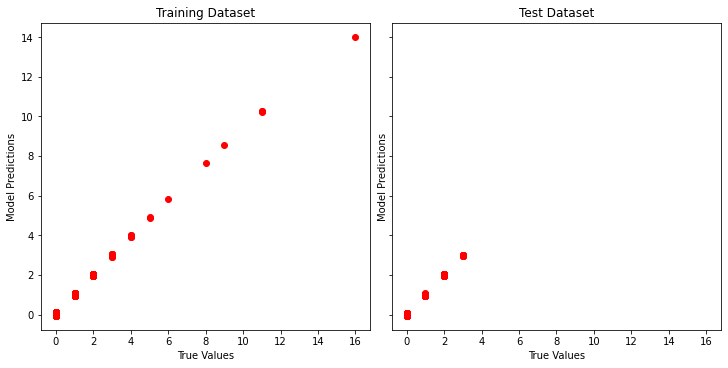

In [206]:
plot_results(y_train, y_pred_train, y_test, y_pred_test)

As it can be seen from the plots, the shallow neural network architechture shows by far the best performance of all methods considered in this notebook.  However in order to evaluate the mean poisson deviance special considerations had to be taken.  Since Scikit-Learn's `mean_poisson_deviance` function works only with strictly positive values of `y_pred` a ReLU activation in the output layer was considered initially.  This had as a consequence that basically all predicted values were enforced to be zero which resulted in an extremly poor performance and made an evaluation of the deviance impossible anyway.  To avoid this no activation was considered in the output layer.  Instead to evaluate the deviance only absolute values of `y_pred` were considered.  Additionally to avoid numerical problems due to null preditction values a very small offset was considered as well.  The resulting mean poisson deviance values seem plausible when compared to the prediction value vs. ground truth plots.